In [146]:
import pydicom
import numpy as np
from skimage.transform import resize,rescale
from skimage import img_as_ubyte
import matplotlib.pyplot as plt
import os
import pandas as pd

# hough ellipse transform
from skimage import data, color, img_as_ubyte
from skimage.feature import canny
from skimage.transform import hough_ellipse, resize
from skimage.draw import ellipse_perimeter
from skimage.color import gray2rgb
import skimage.io as io

# inmediate data process
from utils import normalize, get_rois, plot_axis, read_data
from utils import read_rois_and_axis_data

# segmentation
from segmentation_model import unet_model

# detection
from detection_model import Net, num_classes
from detection_machine import Detection

# hyperparameters
from utils import input_size, img_height, img_width

In [79]:
# read rois imgs and rois_axis_ens from the detextion result
dir_rois = r'.\intermediate_results'
rois_ens, rois_axis_ens = read_rois_and_axis_data(dir_rois)

# 对于 rois data 的 pre process
copy = rois_ens.copy()
for i,rois in enumerate(copy): 
    rois = resize(rois.transpose(1,2,0), (img_height, img_width)).transpose(2,0,1)  
    rois = img_as_ubyte(normalize(rois))        # 先normalization变成-1到1，再变成uint8
    rois = rois[:,:,:,np.newaxis]
    rois_ens[i] = rois
print(rois_ens[0].shape)

# 对于 axis 的 pre process
copy = rois_axis_ens.copy()
for i,rois_axis in enumerate(copy): 
    rois_axis[:,[1,0]] = rois_axis[:,[0,1]]  # 交换一下x和y的位置
    rois_axis = np.concatenate((rois_axis, np.array(input_size)[:,np.newaxis].repeat(rois_axis.shape[0], axis=1).T), axis=1)
    rois_axis_ens[i] = rois_axis
print(rois_axis_ens[0].shape)

(7, 128, 128, 1)
(7, 4)


In [80]:
# segmentation part
input_shape = (img_height, img_width)

## mid
model1 = unet_model(input_shape)
model1.load_weights("./segmentation_model_weights/weights_unet1.hdf5")

## both sides
model2 = unet_model(input_shape)
model2.load_weights("./segmentation_model_weights/weights_unet2.hdf5")

In [81]:
Y1_pred = []
Y2_pred = []
for rois, rois_axis in zip(rois_ens, rois_axis_ens):
    y1_pred = model1.predict(rois).squeeze()
    y2_pred = model2.predict(rois).squeeze()
    
    y1_pred = resize(y1_pred.transpose(1,2,0), input_size).transpose(2,0,1)  
    y2_pred = resize(y2_pred.transpose(1,2,0), input_size).transpose(2,0,1) 
    
    Y1_pred.append(y1_pred)
    Y2_pred.append(y2_pred)
print(Y1_pred[0].shape)
print(Y2_pred[0].shape)

(7, 36, 36)
(7, 36, 36)


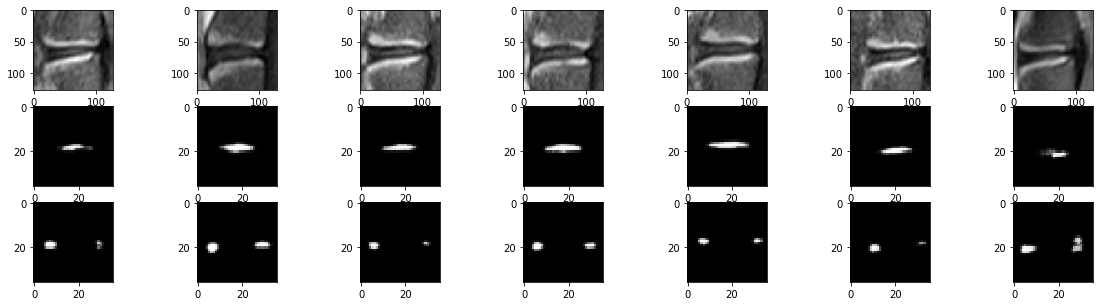

In [82]:
# show the first exemple 
N = Y1_pred[0].shape[0]
plt.figure(figsize=(20,5))
for i in range(N):
    plt.subplot(3,N,i+1)
    plt.imshow(rois_ens[0][i].squeeze(), cmap = 'gray')
    
    plt.subplot(3,N,i+N+1)
    plt.imshow(Y1_pred[0][i],cmap = 'gray')
    
    plt.subplot(3,N,i+2*N+1)
    plt.imshow(Y2_pred[0][i],cmap = 'gray')
plt.show()

In [83]:
def ims_size_match(ims, tgt_size):
    '''resize, 对每一个im单独resize(for 循环)， 因为ims里面的im 的size可能本来就不一样, resize之后强行转换为float格式(int16->float64)'''
    new_ims = []
    for im in ims:
        im = resize(im, tgt_size)
        new_ims.append(im)
    return np.array(new_ims)

In [165]:
# recalage automatique et recherche de valeur
root_path = 'D:\课件\ECN第二年DATASIM\Projet\projet mapping segmentation\IRM_brut'
ims_T1sag, ims_T1, ims_T2sag, ims_T2, ims_T2star, pos, axis_ens_T1, axis_ens_T2, axis_ens_T2star = read_data(root_path, if_normalized=True)
_, ims_T1, _, ims_T2, ims_T2star, _, _, _, _ = read_data(root_path, if_normalized=False) # 读取没有normalization的数据

inds = [58, 63, 68]
names = []
for i in inds:
    p = pos[i]
    name = p[p.find('Brebis'):p.find('Brebis')+21]
    names.append(name)
names

test_T1 = ims_T1[inds]
test_T2 = ims_T2[inds]
test_T2star = ims_T2star[inds]
test_axis_ens_T1 = axis_ens_T1
test_axis_ens_T2 = axis_ens_T2
test_axis_ens_T2star = axis_ens_T2star

In [234]:
class semi_auto_registration():
    def __init__(self, Y1_pred, Y2_pred, src_rois_axis_ens, src_input_size, 
                 ims_T1, ims_T2, ims_T2star, axis_ens_T1, axis_ens_T2, axis_ens_T2stare):
        self.Y1_pred = Y1_pred
        self.Y2_pred = Y2_pred
        self.ims_T1 = ims_T1
        self.ims_T2 = ims_T2
        self.ims_T2star = ims_T2star
        self.axis_ens_T1 = axis_ens_T1
        self.axis_ens_T2 = axis_ens_T2
        self.axis_ens_T2star = axis_ens_T2star
        self.src_size = (512,512)
        self.src_roi_size = Y1_pred[0].shape[1:]
        self.src_input_size = src_input_size
        self.src_rois_axis_ens = src_rois_axis_ens.copy()
        
    def get_rois(self, type_im):
        if type_im == 'T1':
            ims = self.ims_T1
            tgt_axis_ens = self.axis_ens_T1
        elif type_im == 'T2':
            ims = self.ims_T2
            tgt_axis_ens = self.axis_ens_T2  
        elif type_im == 'T2star':
            ims = self.ims_T2
            tgt_axis_ens = self.axis_ens_T2
        else:
            print('wrong type(should be T1, T2 or T2star)')
            return
        
        rois_ens = []
        Y1_pred_ens = []
        Y2_pred_ens = []
        for i, (im, tgt_axis) in enumerate(zip(ims, tgt_axis_ens)):
            y1_pred = self.Y1_pred[i].copy()
            y2_pred = self.Y2_pred[i].copy()
            
            # 注意下面src何tgt都有按照y轴从上到下排序的过程
            # registration of mask
            tgt_size = im.shape
            tgt_roi_size = (int(tgt_size[0]/self.src_size[0]*self.src_roi_size[0]), int(tgt_size[1]/self.src_size[1]*self.src_roi_size[1]))
            y1_pred = resize(y1_pred.transpose(1,2,0), tgt_roi_size).transpose(2,0,1) 
            y2_pred = resize(y2_pred.transpose(1,2,0), tgt_roi_size).transpose(2,0,1) 
            
            order = np.argsort(self.src_rois_axis_ens[i][:,1])
            y1_pred = y1_pred[order]
            y2_pred = y2_pred[order]
            
            # read rois
            rois, tgt_axis = self.get_rois_from_points_axis(im, tgt_axis, tgt_roi_size)
            order = np.argsort(tgt_axis[:,1])
            rois = rois[order]
            
            while len(rois) < len(y1_pred):
                y1_pred = np.delete(y1_pred, obj = 0, axis = 0)
                y2_pred = np.delete(y2_pred, obj = 0, axis = 0)
                
            rois_ens.append(rois)
            Y1_pred_ens.append(y1_pred)
            Y2_pred_ens.append(y2_pred)
            
        return rois_ens, Y1_pred_ens, Y2_pred_ens
                
    def get_rois_from_points_axis(self, im, axis, rec_size):
        rois = []
        new_axis = []
        for x,y in axis:
            if y+rec_size[0]//2 < im.shape[0] and y-rec_size[0]//2>0:
                roi = im[y-rec_size[0]//2:y+rec_size[0]//2, x-rec_size[1]//2:x+rec_size[1]//2]
                rois.append(roi)
                new_axis.append([x,y])
        return np.array(rois), np.array(new_axis)
    
    def get_values(self, rois_ens, Y1_pred, Y2_pred):
        Y1_mean = []
        Y1_max = []
        Y1_min = []
        Y2_mean = []
        Y2_max = []
        Y2_min = []
        for rois, y1_pred, y2_pred in zip(rois_ens, Y1_pred, Y2_pred):
            #y1_pred = (y1_pred > y1_pred.mean())   # (8, 36, 36),如果加上这段代码，就是希望做0/1的mask,否则就是smooth的mask
            n1_pred = y1_pred.sum()                # 对八张图片全部加和
            #y2_pred = (y2_pred > y2_pred.mean())
            n2_pred = y2_pred.sum() 
            
            y1_mean, y1_max, y1_min = (rois * y1_pred).sum()/n1_pred, (rois * y1_pred).max(), (rois * y1_pred).min()
            y2_mean, y2_max, y2_min = (rois * y2_pred).sum()/n2_pred, (rois * y2_pred).max(), (rois * y2_pred).min()
        
            Y1_mean.append(y1_mean)
            Y1_max.append(y1_max)
            Y1_min.append(y1_min)
            Y2_mean.append(y2_mean)
            Y2_max.append(y2_max)
            Y2_min.append(y2_min)
            
        data_pred = pd.DataFrame(zip(names, Y1_mean, Y1_max, Y1_min, Y2_mean, Y2_max, Y2_min),
                                 columns=['path',
                                         'valeur moyenne (central)','valeur max (central)','valeur min (central)',
                                         'valeur moyenne (cote)','valeur max (cote)','valeur min (cote)'])
        return data_pred
    
    def draw_figures(self, rois_ens, Y1_pred, Y2_pred):
        for j, (rois, y1_pred, y2_pred) in enumerate(zip(rois_ens, Y1_pred, Y2_pred)):
            print(names[j])
            plt.figure(figsize = (14, 7))
            for i, (roi, y1_p, y2_p) in enumerate(zip(rois, y1_pred, y2_pred)):
                plt.subplot(3,7,i+1)
                plt.imshow(roi, cmap='gray')
                plt.subplot(3,7,i+1+7)
                plt.imshow(y1_p, cmap='gray')
                plt.subplot(3,7,i+1+2*7)
                plt.imshow(y2_p, cmap='gray')
            plt.show()

In [235]:
segmentation_model = semi_auto_registration(Y1_pred, Y2_pred, rois_axis_ens, input_size, test_T1, 
                                            test_T2, test_T2star, test_axis_ens_T1, test_axis_ens_T2, test_axis_ens_T2star)
rois_ens_T1, Y1_pred_T1, Y2_pred_T1 = segmentation_model.get_rois('T1')
data_pred1 = segmentation_model.get_values(rois_ens_T1, Y1_pred_T1, Y2_pred_T1)
data_pred1.to_csv(r'C:\Users\chenq\Desktop\T1.csv') # 保存为csv
print(data_pred1)

                    path  valeur moyenne (central)  valeur max (central)  \
0  Brebis 7 (40560)\J-7\                601.181641           1249.447266   
1  Brebis 8 (40141)\J-7\                540.540344            946.335571   
2  Brebis 9 (40295)\J-7\                608.696106           1025.150879   

   valeur min (central)  valeur moyenne (cote)  valeur max (cote)  \
0                   0.0             482.154633         703.768005   
1                   0.0             356.568176         895.216919   
2                   0.0             414.236694         939.133057   

   valeur min (cote)  
0                0.0  
1                0.0  
2                0.0  


In [236]:
rois_ens_T2, y1_pred_T2, y2_pred_T2 = segmentation_model.get_rois('T2')
data_pred2 = segmentation_model.get_values(rois_ens_T2, y1_pred_T2, y2_pred_T2)
data_pred2.to_csv(r'C:\Users\chenq\Desktop\T2.csv') # 保存为csv
print(data_pred2)

                    path  valeur moyenne (central)  valeur max (central)  \
0  Brebis 7 (40560)\J-7\                 91.876022            881.554626   
1  Brebis 8 (40141)\J-7\                 56.564625            341.908173   
2  Brebis 9 (40295)\J-7\                 60.305401            117.160233   

   valeur min (central)  valeur moyenne (cote)  valeur max (cote)  \
0                   0.0              40.723515         288.351776   
1                   0.0              38.879269          55.880287   
2                   0.0              43.108814         226.308990   

   valeur min (cote)  
0                0.0  
1                0.0  
2                0.0  


Brebis 7 (40560)\J-7\


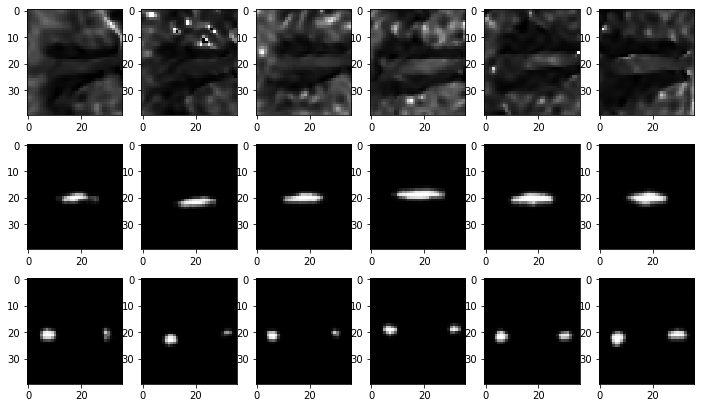

Brebis 8 (40141)\J-7\


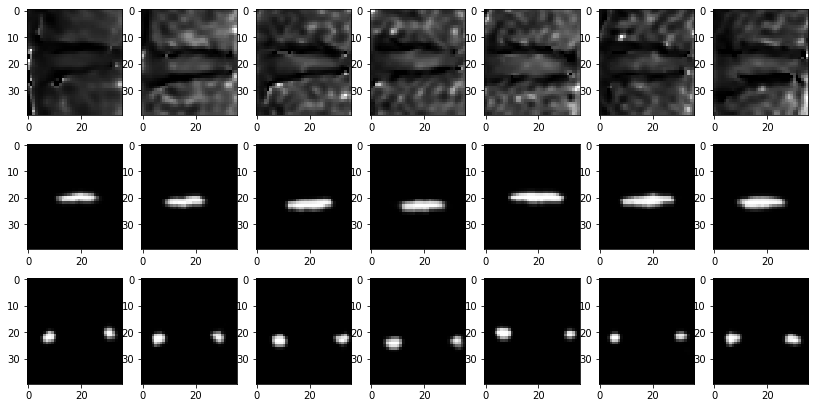

Brebis 9 (40295)\J-7\


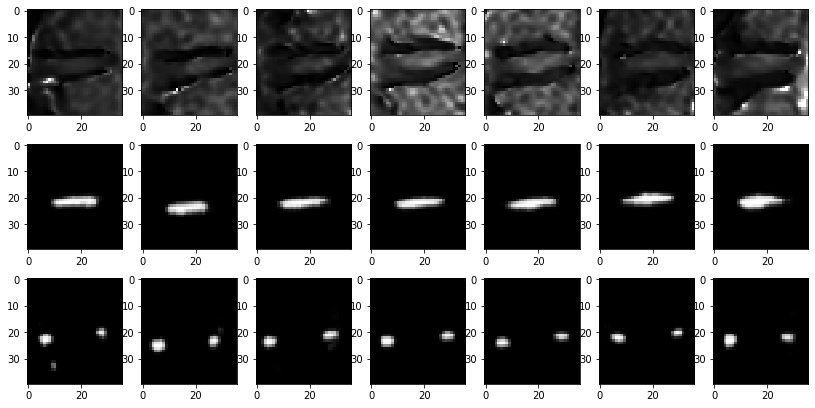

In [237]:
segmentation_model.draw_figures(rois_ens_T1, Y1_pred_T1, Y2_pred_T1)

# Match Md1 recalage
## 发现简单的recalage是不能一一对应的，表示不同类型的图像没有简单的一一位置对应关系

In [5]:
def axis_size_match(axis_ens, src_size, tgt_size):
    new_axis_ens = axis_ens.copy()
    
    x_scale = tgt_size[1]*1.0/src_size[1]
    y_scale = tgt_size[0]*1.0/src_size[0]
    
    new_axis_ens[:,0] = np.round(new_axis_ens[:,0]*x_scale)              # x
    new_axis_ens[:,1] = np.round(new_axis_ens[:,1]*y_scale)              # y
    new_axis_ens[:,2] = np.round(new_axis_ens[:,2]*x_scale)              # w
    new_axis_ens[:,3] = np.round(new_axis_ens[:,3]*y_scale)              # h
    
    return new_axis_ens

In [6]:
# 之前用的是T1 SAG文件，找到其对应的T1，T2和T2*文件
## T1 SAG
f0 = r'D:\课件\ECN第二年DATASIM\Projet\projet mapping segmentation\IRM_process\Brebis13\5\T1_TSE_SAG\IM-0003-0004.dcm'
ds0 = pydicom.dcmread(f0)      # dcm format 
im0 = ds0.pixel_array          # array 这里train data是（512，512） dtype = int16

## T1
f1 = r'D:\课件\ECN第二年DATASIM\Projet\projet mapping segmentation\IRM_process\Brebis13\5\T1_images\IM-0010-0012.dcm'
ds1 = pydicom.dcmread(f1)     
im1 = ds1.pixel_array          

im1_mean, im1_std = im1.mean(), im1.std() 
im1 = (im1-im1.mean())/im1.std()   

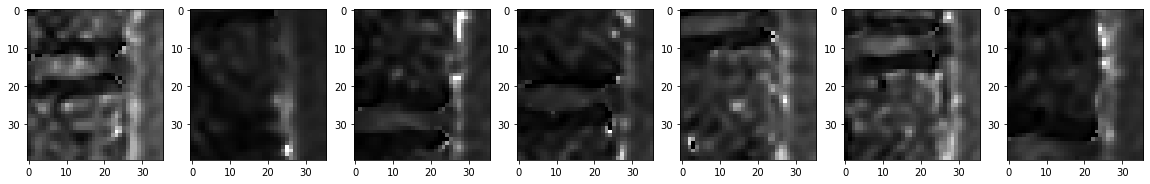

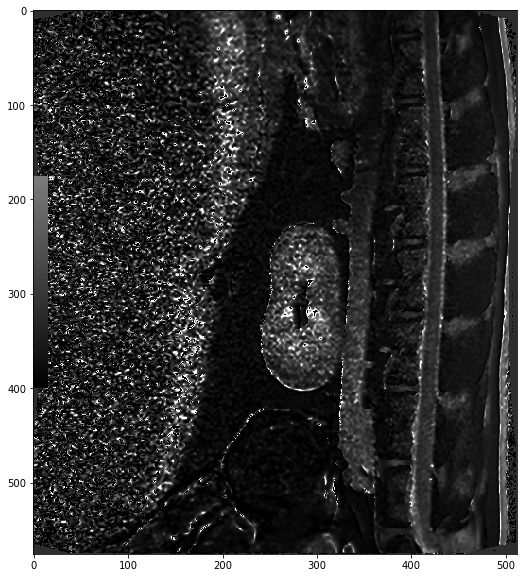

In [7]:
# axis match
rois_axis_ens_matched = axis_size_match(rois_axis_ens, im0.shape, im1.shape)
im1_rois = get_rois(im1, rois_axis_ens_matched, if_modify_size = False)

plt.figure(figsize=(20,5))
for i in range(N):
    plt.subplot(1,N,i+1)
    plt.imshow(im1_rois[i].squeeze(), cmap = 'gray')
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(im1, cmap = 'gray')
plt.show()

In [125]:
root_path = r'D:\课件\ECN第二年DATASIM\Projet\projet mapping segmentation\IRM_process'
ims_T1sag, ims_T1, ims_T2sag, ims_T2, ims_T2star, pos = read_data(root_path, if_normalized = True)

# resize + normalize(scale 0~1), resize的时候要暂时将channels维度放在最后一维上
tgt_size = ims_T1sag.shape[1:]
ims_T1sag = normalize(ims_T1sag)
ims_T2sag = normalize(ims_T2sag)
ims_T1 = normalize(ims_size_match(ims_T1, tgt_size))
ims_T2 = normalize(ims_size_match(ims_T2, tgt_size))
ims_T2star = normalize(ims_size_match(ims_T2star, tgt_size))

print(ims_T1sag.mean(), ims_T1sag.dtype)
print(ims_T2sag.mean(), ims_T2sag.dtype)
print(ims_T1.mean(), ims_T1.dtype)
print(ims_T2.mean(), ims_T2.dtype)
print(ims_T2star.mean(), ims_T2star.dtype)

0.088377652164533 float64
0.0840462519440932 float64
0.13670565448687144 float64
0.03845100690364558 float64
0.012676802778167491 float64


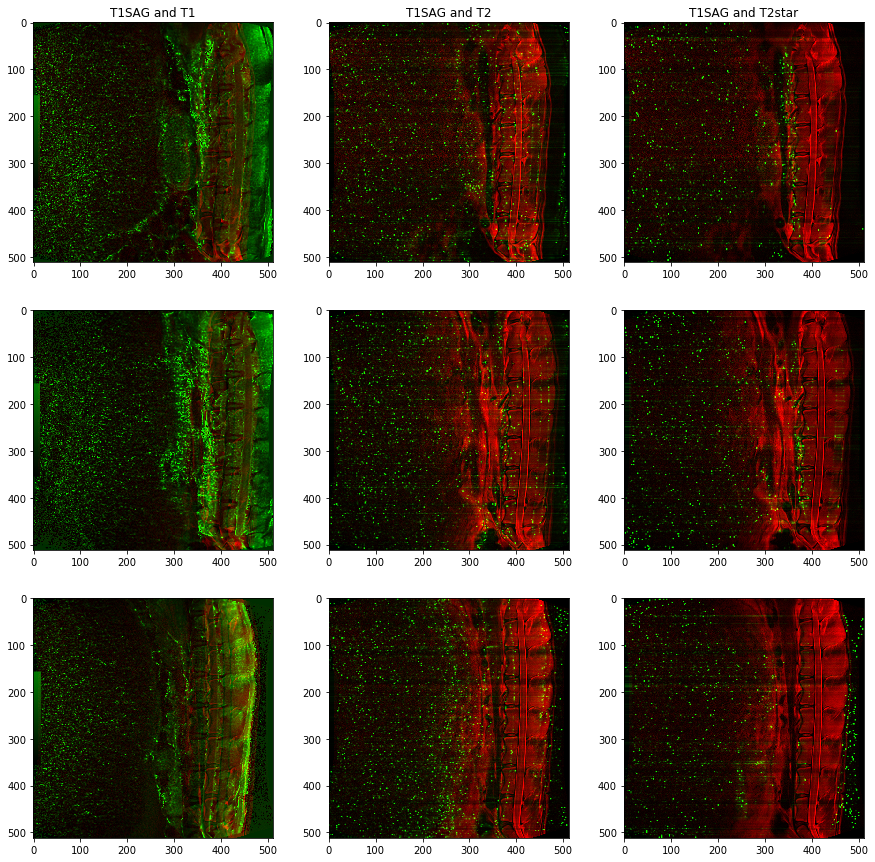

In [128]:
# show fusion images
N = 3
plt.figure(figsize=(5*3,5*N))
for i in range(N):
    im_T1sag = ims_T1sag[i]
    im_T2sag = ims_T2sag[i]
    im_T1 = ims_T1[i]
    im_T2 = ims_T2[i]
    im_T2star = ims_T2star[i]
    
    blend1 = np.zeros((tgt_size[0], tgt_size[1], 3))
    blend1[:,:,0] = im_T1sag       # red channe;
    blend1[:,:,1] = im_T1          # green channe;
    
    blend2 = np.zeros((tgt_size[0], tgt_size[1], 3))
    blend2[:,:,0] = normalize(im_T2sag)     
    blend2[:,:,1] = normalize(im_T2)          
    
    blend3 = np.zeros((tgt_size[0], tgt_size[1], 3))
    blend3[:,:,0] = normalize(im_T2sag)       
    blend3[:,:,1] = normalize(im_T2star)     
    
    plt.subplot(N,3,3*i+1)
    plt.imshow(blend1)
    if i == 0:
        plt.title('T1SAG and T1')
    plt.subplot(N,3,3*i+2)
    plt.imshow(blend2)
    if i == 0:
        plt.title('T1SAG and T2')
    plt.subplot(N,3,3*i+3)
    plt.imshow(blend3)
    if i == 0:
        plt.title('T1SAG and T2star')
    
plt.show()

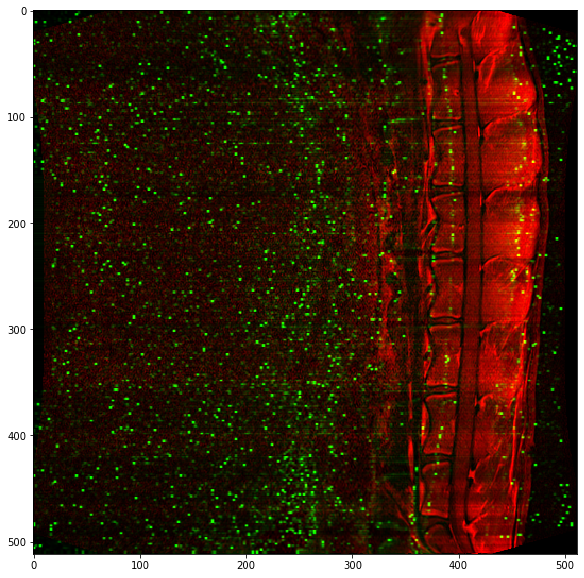

In [111]:
# Show overlap
plt.figure(figsize=(10,10))
plt.imshow(blend2)
plt.show()

In [124]:
# save fusion images 
dir_fusion = './fusion'
if not os.path.exists(dir_fusion):
    os.makedirs(dir_fusion)

N = 1
for i in range(N):
    im_T1sag = ims_T1sag[i]
    im_T1 = ims_T1[i]
    im_T2 = ims_T2[i]
    im_T2star = ims_T2star[i]

    blend1 = np.zeros((tgt_size[0], tgt_size[1], 3))
    blend1[:,:,0] = im_T1sag       # red channe;
    blend1[:,:,1] = im_T1          # green channe;
    
    blend2 = np.zeros((tgt_size[0], tgt_size[1], 3))
    blend2[:,:,0] = normalize(im_T1sag)       # red channe;
    blend2[:,:,1] = normalize(im_T2)          # green channe;
    
    blend3 = np.zeros((tgt_size[0], tgt_size[1], 3))
    blend3[:,:,0] = im_T1sag       # red channe;
    blend3[:,:,1] = im_T2star      # green channe;
    
    io.imsave(os.path.join(dir_fusion, str(i+1)+'_T1sag&T1'+'.tiff'), blend1.astype(np.float32))
    io.imsave(os.path.join(dir_fusion, str(i+1)+'_T1sag&T2'+'.tiff'), blend2.astype(np.float32))   
    io.imsave(os.path.join(dir_fusion, str(i+1)+'_T1sag&T2star'+'.tiff'), blend3.astype(np.float32))   

# Match Md2 Ellipse

In [ ]:
def axis_from_xyabo_to_xywh(axis_ens):
    axis_out = []
    for (x,y,a,b,orientation) in axis_ens:
        # orientation 是从0到pi的,0的时候是竖直的,pi/2的时候是水平的
        if orientation%np.pi > 3/4*np.pi or orientation%np.pi < 1/4*np.pi:
            x1 = x - round(a*np.sin(orientation))
            y1 = y - round(b*np.abs(np.cos(orientation)))
            w = round(2*a*np.sin(orientation))
            h = round(2*b*np.abs(np.cos(orientation)))
        else:
            x1 = x - round(a*np.abs(np.cos(orientation)))
            y1 = y - round(b*np.sin(orientation))
            w = round(2*b*np.sin(orientation))
            h = round(2*a*np.abs(np.cos(orientation)))
        axis_out.append([x1, y1, w, h])
    return np.array(axis_out)

In [ ]:
axis_ellipse_cen = []
axis_ellipse_left = []
axis_ellipse_right = []
plt.figure(figsize = (N*5,4*5))
for i in range(N):
    roi = rois[i].squeeze()
    y1_pred = Y1_pred[i]
    y2_pred = Y2_pred[i]
    
    #1/ original rois prediction
    plt.subplot(3,N,i+1)
    plt.imshow(roi,cmap='gray')
    
    #2/ center
    # Perform a Hough Transform
    edges = canny(y1_pred, sigma=5)
    result = hough_ellipse(edges, accuracy=5, threshold=1)
    result.sort(order='accumulator')
    # Estimated parameters for the ellipse
    best = list(result[-1])
    yc, xc, a, b = [int(round(x)) for x in best[1:5]]
    orientation = best[5]
    # Draw the ellipse on the original image
    cy, cx = ellipse_perimeter(yc, xc, a, b, orientation)
    init = np.array([cx, cy]).T   
    
    plt.subplot(3,N,N+i+1)
    plt.imshow(y1_pred,cmap='gray')
    plt.plot(init[:, 0], init[:, 1], '--r', lw=2)
    
    #3/ both sides
    y2_pred = Y2_pred[i]
    y2_pred_left = y2_pred.copy()
    y2_pred_left[:,y2_pred_left.shape[1]//2:] = 0
    y2_pred_right = y2_pred.copy()
    y2_pred_right[:,:y2_pred_right.shape[1]//2] = 0
    
    ## 3.1/ left
    # Perform a Hough Transform
    edges = canny(y2_pred_left, sigma=5)
    result = hough_ellipse(edges, accuracy=5, threshold=1)
    result.sort(order='accumulator')
    # Estimated parameters for the ellipse
    best1 = list(result[-1])
    yc1, xc1, a1, b1 = [int(round(x)) for x in best1[1:5]]
    orientation1 = best1[5]
    # Draw the ellipse on the original image
    cy1, cx1 = ellipse_perimeter(yc1, xc1, a1, b1, orientation1)
    init1 = np.array([cx1, cy1]).T 
    
    ## 3.2/ right
    edges = canny(y2_pred_right, sigma=5)
    result = hough_ellipse(edges, accuracy=5, threshold=1)
    result.sort(order='accumulator')
    # Estimated parameters for the ellipse
    best2 = list(result[-1])
    yc2, xc2, a2, b2 = [int(round(x)) for x in best2[1:5]]
    orientation2 = best2[5]
    # Draw the ellipse on the original image
    cy2, cx2 = ellipse_perimeter(yc2, xc2, a2, b2, orientation2)
    init2 = np.array([cx2, cy2]).T 
    
    plt.subplot(3,N,2*N+i+1)
    plt.imshow(y2_pred,cmap='gray')
    plt.plot(init1[:, 0], init1[:, 1], '--r', lw=2)
    plt.plot(init2[:, 0], init2[:, 1], '--r', lw=2)
    
    # save to variables
    axis_ellipse_cen.append([xc, yc, a, b, orientation])
    axis_ellipse_left.append([xc1, yc1, a1, b1, orientation1])
    axis_ellipse_right.append([xc2, yc2, a2, b2, orientation2])

plt.show()

print(axis_ellipse_cen)
axis_ellipse_cen = axis_from_xyabo_to_xywh(axis_ellipse_cen)
axis_ellipse_left = axis_from_xyabo_to_xywh(axis_ellipse_left)
axis_ellipse_right = axis_from_xyabo_to_xywh(axis_ellipse_right)
print(axis_ellipse_cen)

In [ ]:
plt.figure()
plt.imshow(roi,cmap='gray')
cy, cx = ellipse_perimeter(64, 64, 20, 5, 3*np.pi/4)
init = np.array([cx, cy]).T 
plt.plot(init[:, 0], init[:, 1], '-r', lw=1)

In [ ]:
plt.figure(figsize = (N*5,4*5))
for i in range(N):
    roi = rois[i].squeeze()
    y1_pred = Y1_pred[i]
    y2_pred = Y2_pred[i]
    
    #1/ original rois prediction
    plt.subplot(3,N,i+1)
    plt.imshow(roi,cmap='gray')
    
    #2/ center
    plt.subplot(3,N,N+i+1)
    plt.imshow(y1_pred,cmap='gray')
    plot_axis(axis_ellipse_cen[i], shape = 'ellipse')
    
    ## 3.
    plt.subplot(3,N,2*N+i+1)
    plt.imshow(y2_pred,cmap='gray')
    plot_axis(axis_ellipse_left[i], shape = 'ellipse')
    plot_axis(axis_ellipse_right[i], shape = 'ellipse')
    
plt.show()

# Match Md3 Semi-automatique 位置人工确定

最终用这个方法，见前